In [1]:
from src.tools import MMseqs, NCBIDatasets
import pandas as pd
import numpy as np
from src.files import XMLFile, InterProScanFile, FASTAFile, GBFFFile
from utils import * 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from src.classifier import Classifier
from src.sampler import Sampler
from src.dataset import Dataset

%load_ext autoreload 
%autoreload 2

In [8]:
ncbi_genome_metadata_df = load_ncbi_genome_metadata()

for level in ['phylum', 'class', 'order', 'genus']:
    print(f'{level.capitalize()} count:', ncbi_genome_metadata_df[f'{level}'].nunique())
    # print(f'Species with no {level}:', (genome_metadata_df[f'{level}_taxid'] == 'none').sum())

# fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(15, 5), width_ratios=[0.3, 0.7])

# counts, bins, _ = ax_a.hist(ncbi_genome_metadata_df.gc_percent, bins=25, width=2, edgecolor='black', color='lightgray')
# ax_a.set_ylabel('density')
# ax_a.set_xlabel('GC percent')

# level = 'phylum'
# # x = np.arange(genome_metadata_df[f'{level}_taxid'].nunique())
# y = ncbi_genome_metadata_df.groupby(level).gc_percent.mean() # .sort_values(ascending=True)
# x = ncbi_genome_metadata_df.groupby(level).apply(len, include_groups=False) # .sort_values(ascending=True)
# y_err = ncbi_genome_metadata_df.groupby(level).apply(lambda df : df.gc_percent.std() / np.sqrt(len(df)), include_groups=False) # .loc[y.index]

# ax_b.errorbar(x, y, yerr=y_err, ls='', lw=0.7, capsize=2, color='black')
# ax_b.scatter(x, y, color='black', s=5)
# ax_b.set_xscale('log')
# ax_b.set_xlabel(f'log({level} size)')
# ax_b.set_ylabel('GC percent')

plt.show()

Phylum count: 56
Class count: 123
Order count: 299
Genus count: 3983


In [4]:
# How should I select the genomes for model training?

# Using the same genomes for validation as in the Prodigal paper
# Halobacterium salinarum
# Natronomonas pharaonis
# Aeropyrum pernix
model_organism_genome_ids = ['GCF_000005845.2'] # E. coli K-12
model_organism_genome_ids += ['GCF_000009045.1'] # B. subtilis
model_organism_genome_ids += ['GCF_000006765.1'] # P. aeruginosa

# Start by selecting a few phyla in a reasonable size range with varying GC contents.
def sample_genomes(genome_metadata_df:pd.DataFrame, min_phylum_size:int=90, max_phylum_size:int=200):

    phylum_sizes = genome_metadata_df.groupby('phylum').apply(len, include_groups=False)
    phylum_sizes = phylum_sizes[(phylum_sizes > min_phylum_size) & (phylum_sizes < max_phylum_size)]

    genome_metadata_df = genome_metadata_df[genome_metadata_df.phylum.isin(phylum_sizes.index)]
    
    phylum_gc_percent = genome_metadata_df.groupby('phylum').gc_percent.mean() 
    phylum_gc_percent = phylum_gc_percent.sort_values(ascending=True)
    
    phyla = dict()
    phyla['low_gc_content'] = phylum_gc_percent.index[0]
    phyla['med_gc_content'] = phylum_gc_percent.index[len(phylum_gc_percent) // 2]
    phyla['high_gc_content'] = phylum_gc_percent.index[-1]

    print('Low-GC content phylum:', phyla['low_gc_content'])
    print('Medium-GC content phylum:', phyla['med_gc_content'])
    print('High-GC content phylum:', phyla['high_gc_content'])

    genome_ids = {category:genome_metadata_df.index[genome_metadata_df.phylum == phylum] for category, phylum in phyla.items()}
    return genome_ids

genome_ids = sample_genomes(ncbi_genome_metadata_df)

# ncbi = NCBIDatasets(genome_dir='../data/genomes', gbff_dir='../data/proteins/ncbi')
# ncbi.run(genome_ids=genome_ids['low_gc_content'], metadata_only=False)

Low-GC content phylum: Campylobacterota
Medium-GC content phylum: Planctomycetota
High-GC content phylum: Deinococcota


In [5]:
genome_metadata_df = list()
for category, genome_ids_ in genome_ids.items():
    df = ncbi_genome_metadata_df.loc[genome_ids_, :].copy()
    df['gc_percent_category'] = category 
    genome_metadata_df.append(df)
genome_metadata_df = pd.concat(genome_metadata_df)
genome_metadata_df.to_csv('../data/genome_metadata.csv')

In [ ]:
# ! ref --input-path ../data/proteins/prodigal/* --output-dir ../data/ref --reference-dir ../data/proteins/ncbi/ --prodigal-output --summarize

In [7]:
ref_df = load_ref(genome_ids=genome_metadata_df.index)

In [14]:
# Now need to think about how I am going to create the datasets. Definitely will want to start with one per phylum, 
# and for starters, only include things I have definite labels for in the training. 

# Do I want to remove partial sequences? I think maybe not, because there are some sequences labeled partial by Prodigal
# that are not partial in the reference due to incorrect gene boundaries. I'll just keep them all in. 

def build_datasets(genome_metadata_df:pd.DataFrame, phylum:str='Campylobacterota', max_length:int=2000):
    # First remove things which do not have definitive labels. 
    genome_ids = genome_metadata_df[genome_metadata_df.phylum == phylum].index
    print(f'build_datasets: Loading data from {len(genome_ids)} genomes belonging to the phylum {phylum}.')
    df = load_ref(genome_ids=genome_ids)
    print(f'build_datasets: Loaded {len(ref_df)} sequences.')

    df = df[df.spurious | df.real].copy()
    print(f'build_datasets: Kept {df.spurious.sum()} spurious sequences and {df.real.sum()} real sequences.')
    df['label'] = df.real.astype(int)

    lengths = get_lengths(df, top_hit=False)
    print(f'Removing {(lengths >= max_length).sum()} sequences exceeding the maximum length of {max_length}')
    df = df[lengths < max_length]

    mmseqs = MMseqs()
    re = mmseqs.cluster(df, job_name=f'{phylum.lower()}_95', sequence_identity=0.95, reps_only=True, overwrite=False)
    mmseqs.cleanup()

    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idxs, test_idxs = list(gss.split(df, groups=df.genome_id))[0]
    train_df, test_df = df.iloc[train_idxs], df.iloc[test_idxs]
    print(f'build_datasets: Training dataset contains {len(train_df)} sequences, testing dataset contains {len(test_df)} sequences.')
    print(f'build_datasets: {(train_df.label == 0).sum()} negative instances and {(train_df.label == 1).sum()} positive instances in the training dataset.')
    print(f'build_datasets: {(test_df.label == 0).sum()} negative instances and {(test_df.label == 1).sum()} positive instances in the testing dataset.')
    train_df.to_csv(f'../data/{phylum.lower()}_dataset_train.csv')
    test_df.to_csv(f'../data/{phylum.lower()}_dataset_test.csv')
build_datasets(genome_metadata_df)
    



build_datasets: Loading data from 197 genomes belonging to the phylum Campylobacterota.
build_datasets: Loaded 1640383 sequences.
build_datasets: Kept 3845 spurious sequences and 361853 real sequences.
Removing 346 sequences exceeding the maximum length of 2000
MMseqs.load: Removing 44755 non-cluster representatives.
build_datasets: Training dataset contains 288326 sequences, testing dataset contains 77026 sequences.
build_datasets: 2986 negative instances and 285340 positive instances in the training dataset.
build_datasets: 857 negative instances and 76169 positive instances in the testing dataset.


In [ ]:
def get_filter_datasets(max_length:int=800):

    df = load_ref_out()
    print(f'get_filter_datasets: Loaded {len(df)} proteins from ./ref.out')
    df = remove_partial(df)

    interpro_df = InterProScanFile('../data/putative_protein.interpro.tsv').to_df(max_e_value=1e-5, drop_duplicates=True)
    interpro_df.columns = ['interpro_' + col for col in interpro_df.columns]
    df = df.merge(interpro_df, left_index=True, right_index=True, how='left', validate='one_to_one')

    df['length'] = df.seq.apply(len)
    mask = df.length > max_length
    print(f'get_filter_datasets: Removing {mask.sum()} proteins which exceed the maximum specified length of {max_length}.')
    df = df[~mask].copy()

    # Remove this class of sequences, as I am not sure how to tell if they are real. I don't completely trust the InterPro 
    # hit to definitively say it is spurious. Actually, I think I just might remove all putative NCBI sequences.
    mask = df.apply(is_putative_ncbi, axis=1) & ~df.apply(has_interpro_hit, axis=1)
    print(f'get_filter_datasets: Removing {mask.sum()} proteins with putative NCBI hits and no InterPro hit.')
    df = df[~mask]

    labels = df.apply(has_interpro_hit, axis=1) | df.apply(is_validated, axis=1) # This mask is for negative cases. 
    df['label'] = (~labels).astype(int)
    print(f'get_filter_datasets: Laeled {df.label.sum()} proteins as Prodigal errors.')

    mmseqs = MMseqs()
    df = mmseqs.cluster(df, job_name='filter_95', sequence_identity=0.95, reps_only=True, overwrite=True)
    mmseqs.cleanup()

    # I think the right way to split up the dataset might be to hold out particular genomes

    # train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idxs, test_idxs = list(gss.split(df, groups=df.genome_id))[0]
    train_df, test_df = df.iloc[train_idxs], df.iloc[test_idxs]
    print(f'get_filter_datasets: Training dataset contains {len(train_df)} proteins, testing dataset contains {len(test_df)} proteins.')
    train_df.to_csv('../data/filter_dataset_train.csv')
    test_df.to_csv('../data/filter_dataset_test.csv')

    return train_df, test_df


train_df, test_df = get_filter_datasets()


get_filter_datasets: Loaded 464706 proteins from ./ref.out
remove_partial: Removing 4309 sequences marked as partial by both Prodigal and the reference.
get_filter_datasets: Removing 16946 proteins which exceed the maximum specified length of 800.
get_filter_datasets: Removing 34945 proteins with putative NCBI hits and no InterPro hit.
get_filter_datasets: Laeled 7878 proteins as Prodigal errors.
MMseqs.load: Removing 2997 non-cluster representatives.
get_filter_datasets: Training dataset contains 331385 proteins, testing dataset contains 74124 proteins.


In [ ]:
df = pd.concat([train_df, test_df])

mmseqs = MMseqs()
df = mmseqs.cluster(df, job_name='filter_30', sequence_identity=0.30, reps_only=False, overwrite=True)
mmseqs.cleanup()

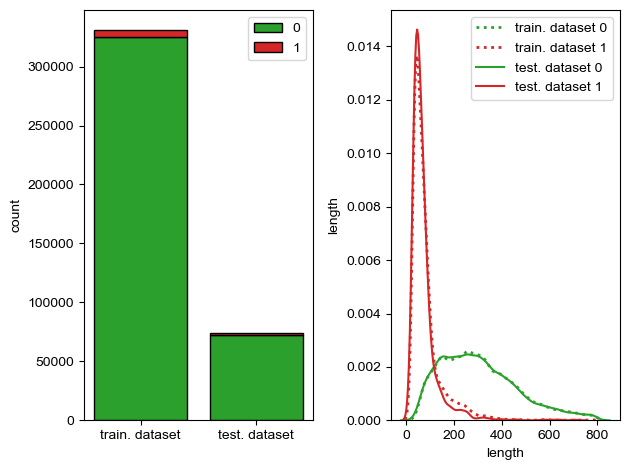

In [ ]:
fig, (ax_a, ax_b) = plt.subplots(ncols=2, layout='tight')

positions, bottom = np.arange(2), np.zeros(2)
colors = {0:'tab:green', 1:'tab:red'}
for label in [0, 1]:
    heights = np.array([(df.label == label).sum() for df in [train_df, test_df]])
    ax_a.bar(positions, heights, bottom=bottom, color=colors[label], edgecolor='black', label=str(label))
    bottom += heights
ax_a.set_ylabel('count')
ax_a.set_xticks([0, 1], labels=['train. dataset', 'test. dataset'])
ax_a.legend()

for label, df in train_df.groupby('label'):
    sns.kdeplot(df.length, color=colors[label], label=f'train. dataset {label}', ax=ax_b, ls=':', lw=2)
for label, df in test_df.groupby('label'):
    sns.kdeplot(df.length, color=colors[label], label=f'test. dataset {label}', ax=ax_b)
ax_b.set_ylabel('density')
ax_b.set_ylabel('length')
ax_b.legend()

plt.show()